In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
output_dir = config['output_dir']
output_dir = './PCA_output_download/'

ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']

In [4]:
stimulus_name = 'natural_movies'  # 'natural_movie_one', 'natural_movie_three'
normalize_unit_fr = True
power_metric = 'Normalized LFP power'

unit_fr_var = 'normalized' if normalize_unit_fr else 'smoothed'

### Get heatmap data from session and probe

In [5]:
exclude_session = [739448407, 743475441]

In [6]:
session_list = set()
for f in os.listdir(output_dir):
    if f.startswith('session'):
        f_strs = os.path.splitext(f)[0].split('_')
        if len(f_strs) > 2 and f_strs[2] == ecephys_structure_acronym:
            if os.path.isdir(os.path.join(output_dir, '_'.join(f_strs[:2]))):
                session_list.add(int(f_strs[1]))
session_list = session_list.difference(exclude_session)
session_list = list(session_list)

In [7]:
power_ds = {}
for session_id in session_list:
    session_dir = os.path.join(output_dir, f'session_{session_id:d}')
    info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
    try:
        with open(info_file) as f:
            info = json.load(f)
        probe_id = info['probe_id']
        probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
        data_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}_power_heatmap_{unit_fr_var:s}_fr.nc')
        pow_ds = xr.load_dataset(data_file)
        pow_ds.load()
    except Exception as e:
        print(e)
        continue
    power_ds[session_id] = pow_ds
    sessions = list(power_ds)
    n_sessions = len(sessions)

### Plot heatmaps

In [8]:
x_data = 'tangent' # 'speed', 'ang', 'tangent'
y_data = 'radial'  # 'mean_fr', 'rms_fr', 'length', 'radial'
transpose = True
n_bins = 10

figsize = (6, 5)

if transpose:
    x_data, y_data = y_data, x_data

In [9]:
heatmap_ds = {}
for session_id, ds in power_ds.items():
    # get quantile grids and average power in grids
    power = ds.power.transpose('wave', 'sample').values
    power_avg, (x_bins, y_bins), hist_count = statistic_in_quantile_grid(
        [ds[x_data], ds[y_data]], power, n_bins=n_bins)
    power_avg = np.swapaxes(power_avg, -1, -2)  # transpose x, y axis

    coords = dict(wave=ds.coords['wave'], x_edge=x_bins, y_edge=y_bins,
        x_bin=range(x_bins.size - 1), y_bin=range(y_bins.size - 1))
    hm_ds = xr.DataArray(power_avg, coords=dict(wave=coords['wave'],
        y_bin=coords['y_bin'], x_bin=coords['x_bin'])).to_dataset(name='power')
    hm_ds = hm_ds.assign_coords(x_edge=coords['x_edge'], y_edge=coords['y_edge'])
    hm_ds = hm_ds.assign(hist_count=xr.DataArray(hist_count,
        coords=dict(x_bin=coords['x_bin'], y_bin=coords['y_bin'])))
    heatmap_ds[session_id] = hm_ds

waves = ds.coords['wave']
n_waves = waves.size
xlabel, ylabel = ds.label.sel(data=[x_data, y_data]).values
xticks_fmt, yticks_fmt = ds.fmt.sel(data=[x_data, y_data]).values

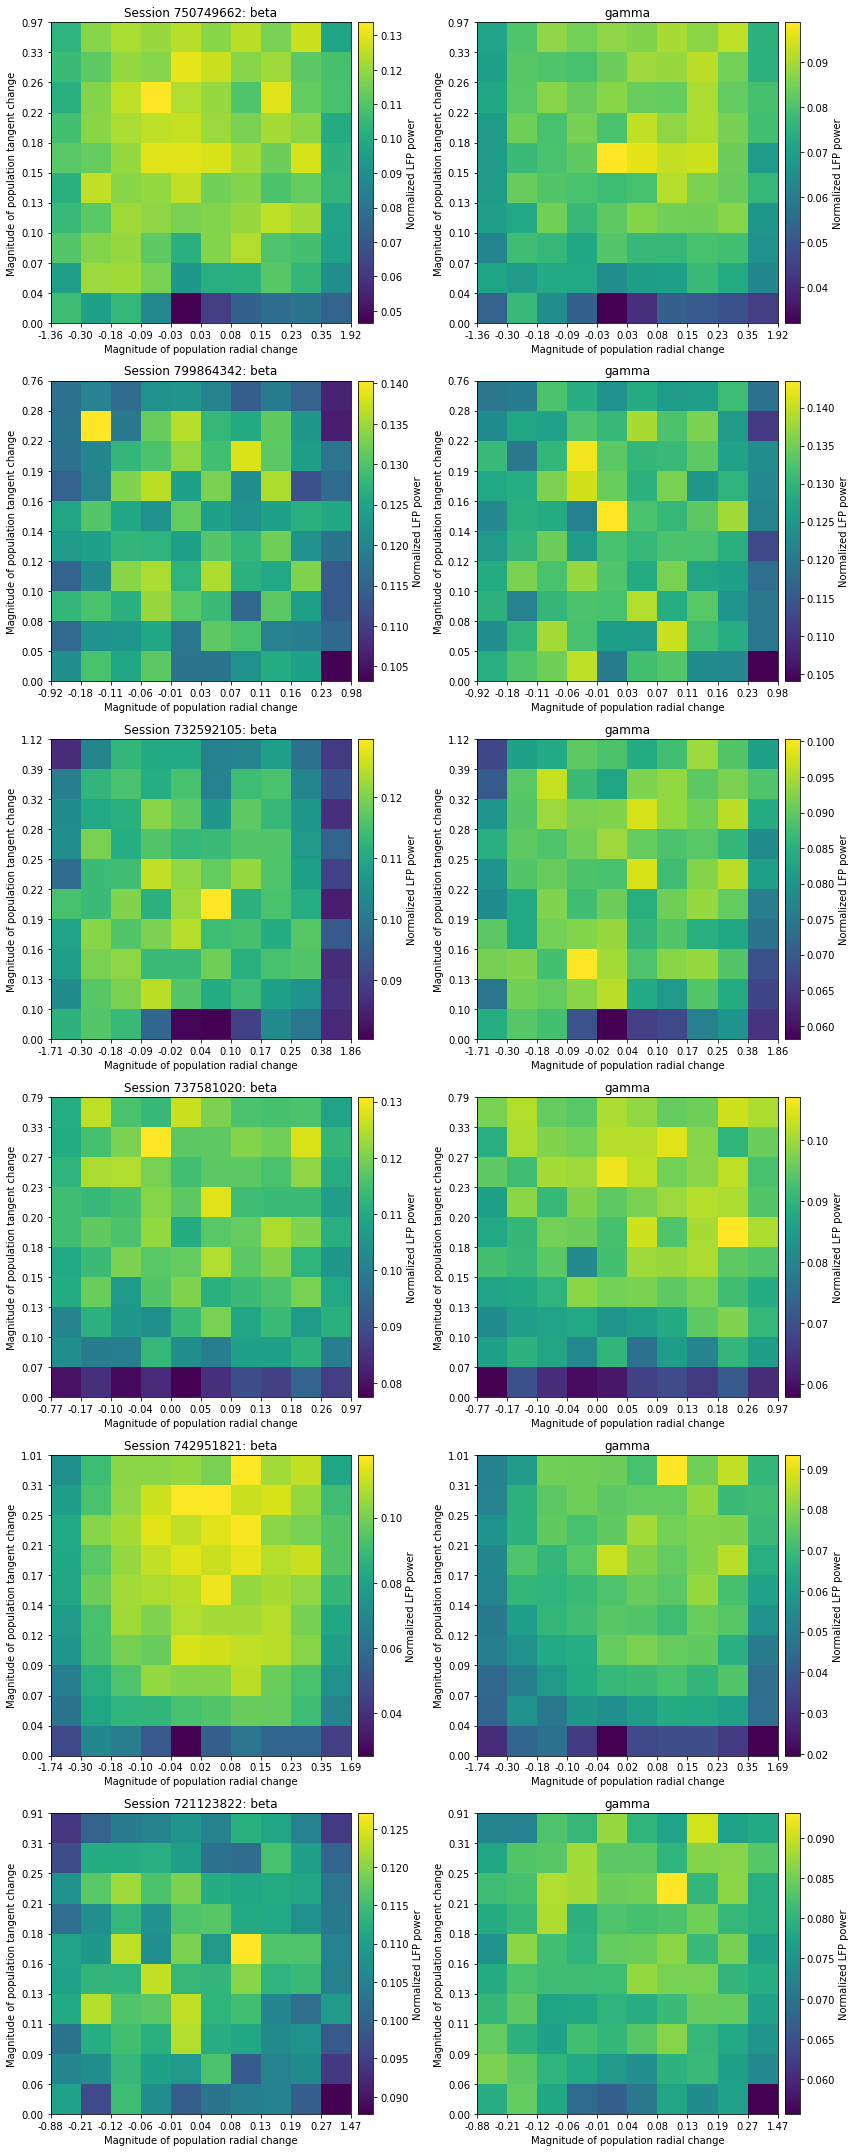

In [10]:
fig, axs = plt.subplots(n_sessions, n_waves, figsize=(n_waves * figsize[0], n_sessions * figsize[1]), squeeze=False)
for i, session_id in enumerate(sessions):
    ds = heatmap_ds[session_id]
    x_bins, y_bins = ds.coords['x_edge'].values, ds.coords['y_edge'].values
    for j, w in enumerate(waves.values):
        ax = axs[i, j]
        pcm = heatmap_in_grid(ds.power.sel(wave=w).values, x_bins, y_bins,
            xticks_fmt=xticks_fmt, yticks_fmt=yticks_fmt,
            even_grid=True, ax=ax)
        plt.colorbar(mappable=pcm, ax=ax, label=power_metric, pad=0.02)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(('' if j else f"Session {session_id:d}: ") + w)
    plt.tight_layout()
plt.show()

### Compile data from all sessions

In [11]:
weighted_by_count = True

heatmap_all_ds = xr.concat([ds[['power', 'hist_count']] for ds in heatmap_ds.values()], dim=pd.Index(heatmap_ds, name='session'))
heatmap_all_da = heatmap_all_ds.power
if weighted_by_count:
    weights = heatmap_all_ds.hist_count
    weights = weights / weights.sum(dim=['x_bin', 'y_bin'])  # proportion of bin in each session
    weights.values[:, ~weights.values.all(axis=0)] = 1.0  # for bins with no count in all sessions
    heatmap_all_da = heatmap_all_da.weighted(weights)
avg_pow = heatmap_all_da.mean(dim='session')  # average

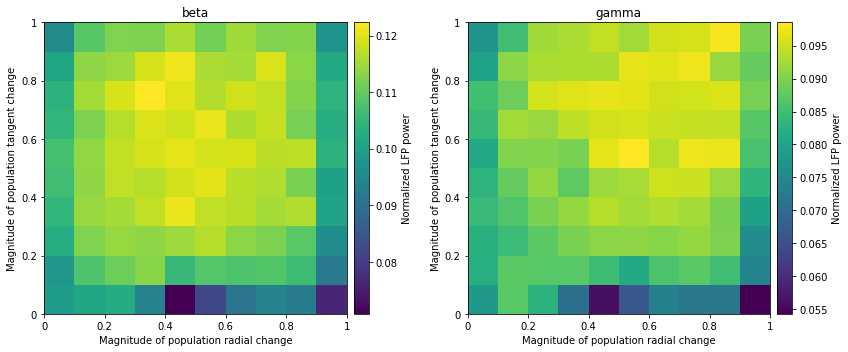

In [12]:
nticks = 6

coords = avg_pow.coords
x_bins = np.linspace(0., 1., coords['x_bin'].size + 1)
y_bins = np.linspace(0., 1., coords['y_bin'].size + 1)

fig, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
for ax, w in zip(axs, waves.values):
    pcm = heatmap_in_grid(avg_pow.sel(wave=w).values, x_bins, y_bins,
        xticks_fmt='{:g}', yticks_fmt='{:g}', even_grid=True, ax=ax)
    ax.get_xaxis().set_major_locator(plt.LinearLocator(numticks=nticks))
    ax.get_yaxis().set_major_locator(plt.LinearLocator(numticks=nticks))
    plt.colorbar(mappable=pcm, ax=ax, label=power_metric, pad=0.02)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(w)
plt.tight_layout()
plt.show()